# Pearson-r cost function

Going through a full cost function calculation to develop functions/check things are working. Functions will be placed in 'inverse/cost.py'

First, quickly go through the process of importing and sorting data, re-ordering, down-sampling and running the model for the resulting frequencies. This is all included in the script 'to be crea'.

In [2]:
import sys, os
sys.path.append("..")

#SCFC modules
from forward import network_transfer as nt
from utils import path as pth
from utils import functions
from brain import Brain
from preprocess import permute

#generic modules
import matplotlib.pyplot as mpl
%matplotlib inline
import numpy as np
import math
from scipy.signal import detrend
from scipy.stats import pearsonr

In [2]:
MEG_path = '/Users/Megan/RajLab/MEG-chang' #insert appropriate path here.
directories = pth.walk_tree(MEG_path)
data = 'DK_timecourse_20_filtered.h5'
freqs = 'DK_timecourse_20_filterfreqs.h5'

dir = directories[0]
abspath = os.path.join(MEG_path,dir)
data_path = os.path.join(abspath, data)
FMEGdata = pth.read_hdf5(data_path)
freq_path = os.path.join(abspath, freqs)
f = pth.read_hdf5(freq_path)

OK, we know that for now we are a bit off with our approach, as the filtering step needs to be improved, but let's continue developing all the necessary functions for a full-blown MCMC anyway. 

Text(0,0.5,'Magnitude')

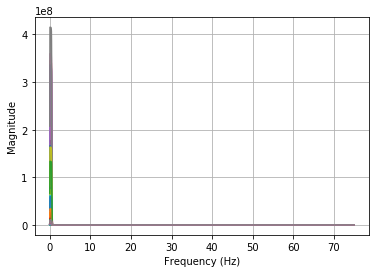

In [3]:
fig = mpl.figure(num=5, figsize = (6,4))
for key in FMEGdata.keys():
    mpl.plot(f,FMEGdata[key])

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude')

Text(0,0.5,'Magnitude (dB)')

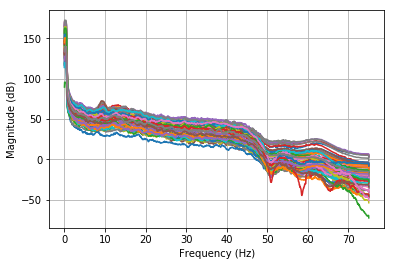

In [5]:
fig2 = mpl.figure(num=5, figsize = (6,4))
for key in FMEGdata.keys():
    mpl.plot(f,functions.mag2db(FMEGdata[key]))

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')

In [6]:
len(f)

4488

As we've established, the frequency resolution is too high, and something has gone wrong here, which needs to be fixed in the filtering/fourier-transform step.

Anyway, for now we will downsample to get a sensible frequency resolution for model comparison. 

### Simple, emergency down-sampling

In [8]:
newf = functions.down_sample_basic(f, 150)
FMEGdownsample = {}
for key in FMEGdata.keys():
    FMEGdownsample[key] = functions.down_sample_basic(FMEGdata[key], 150)

Text(0,0.5,'Magnitude')

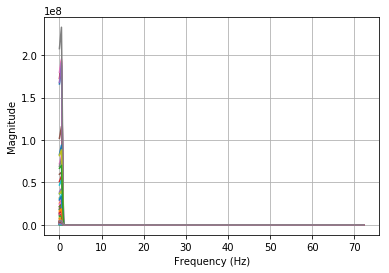

In [15]:
fig3 = mpl.figure(num=5, figsize = (6,4))
for key in FMEGdata.keys():
    mpl.plot(newf,FMEGdownsample[key])

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude')

In [3]:
fig6 = mpl.figure(num=5, figsize = (6,4))
for key in FMEGdata.keys():
    mpl.plot(newf,functions.mag2db(FMEGdownsample[key]))

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')

NameError: name 'FMEGdata' is not defined

In [18]:
len(newf)

150

### Re-order the data to match the calculation HCP order. 

In [10]:
orderfile = '/Users/Megan/RajLab/BRAIN/SCFC-spectral-python/SCFC/dictionaries/HCP_list.h5'
FMEGdownsample = permute.order_dict(FMEGdownsample, orderfile)

### Set up an instance of the brain class and reorder as required

In [11]:
newbrain = Brain.Brain()
hcp_dir = pth.get_sibling_path('data') # connectome information is in /data/ dir
newbrain.add_connectome(hcp_dir) # Use default files in /data/
newbrain.reorder_connectome(newbrain.connectome, newbrain.distance_matrix)
newbrain.bi_symmetric_c()
newbrain.reduce_extreme_dir()

### Running the model with default parameters, using the 'run_forward' function to run for the range of newf.

In [12]:
from forward import runforward as rf
freq_model = rf.run_forward(newbrain, newbrain.ntf_params, newf)

Text(0,0.5,'Magnitude (dB)')

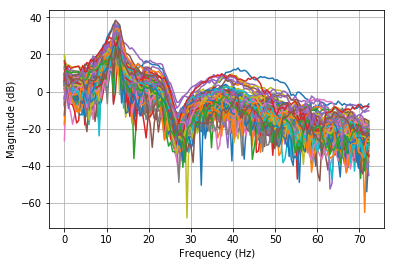

In [13]:
fig4 = mpl.figure(num=5, figsize = (6,4))
for g in range(len(freq_model)):
    mpl.plot(newf,functions.mag2db(np.abs(freq_model[g,:])))

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')

Text(0,0.5,'Magnitude')

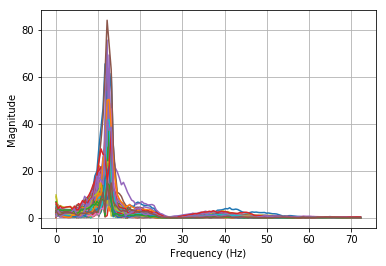

In [14]:
fig5 = mpl.figure(num=5, figsize = (6,4))
for g in range(len(freq_model)):
    mpl.plot(newf,np.abs(freq_model[g,:]))

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude')

In [21]:
freq_model.shape

(86, 150)

### Calculate the pearsonr correlation for each region of the brain and the model.

First, use the linear form of the data/model. We have to make the data in to the correct form of float first.

In [43]:
def pearson_cost_dB(data, model):
    i = 0
    err_list = []
    for key in data.keys():
        modregion = functions.mag2db(freq_model[i,:])
        region = functions.mag2db(data[key])
        region = [float(x) for x in region]#we need to do this to make sure things are in the correct form for scipy.stats
        modregion = [float(x) for x in modregion]
        err = pearsonr(region,modregion)[0]
        err = 1 - err #to convert to an error to minimise. 
        err_list.append(err)
        i += 1
    err = sum(err_list)
    return err, err_list

Run this for the patient we have loaded. 

In [44]:
error, list_of_errors = pearson_cost_dB(FMEGdownsample, freq_model)

In [39]:
error

21.277992021323794

Text(0.5,1,'Errors using data converted to dB')

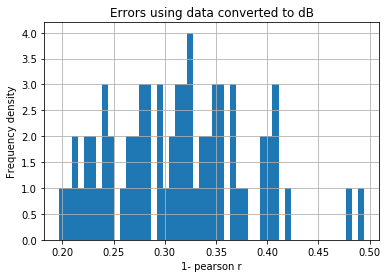

In [53]:
fig7 = mpl.figure(num=5, figsize = (6,4))
mpl.hist(list_of_errors, 50)

mpl.grid(True)
mpl.xlabel('1- pearson r')
mpl.ylabel('Frequency density')
mpl.title('Errors using data converted to dB')

In [45]:
def pearson_cost(data, model):
    i = 0
    err_list = []
    for key in data.keys():
        modregion = freq_model[i,:]
        region = data[key]
        region = [float(x) for x in region]#we need to do this to make sure things are in the correct form for scipy.stats
        modregion = [float(x) for x in modregion]
        err = pearsonr(region,modregion)[0]
        err = 1 - err #to convert to an error to minimise. 
        err_list.append(err)
        i += 1
    err = sum(err_list)
    return err, err_list

In [47]:
lin_errors, list_of_errors_lin = pearson_cost(FMEGdownsample, freq_model)

Text(0.5,1,'Errors using linear data')

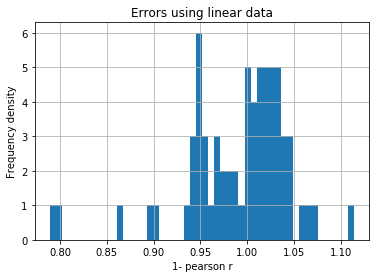

In [52]:
fig8 = mpl.figure(num=5, figsize = (6,4))
mpl.hist(list_of_errors_lin, 50)

mpl.grid(True)
mpl.xlabel('1- pearson r')
mpl.ylabel('Frequency density')
mpl.title('Errors using linear data')